# Final Project Demo Submission

This notebook serves as a demo for the final project submission for the course TCSS 565 - Spatial Databases. The point of this project is to determine whether a user is looking for parking or driving normally based on their GPS data. The training dataset for this is a [Taxi Trajectory dataset](https://www.kaggle.com/datasets/crailtap/taxi-trajectory).


In [1]:
import json
import numpy as np
import pandas as pd
from rich import inspect
from rich.console import Console

# GIS imports
import geopandas as gpd
from shapely.geometry import LineString


In [2]:
# constants
file_path = "data/train.csv"
interval = 4
random_state = 21
sampling_interval = 15
console = Console()

## Data preparation and cleaning

We filter out any coordinates strings that have less than `2 * interval` coordinates. This is to ensure the trip is long enough to get an accurate measurement. Due to the large size of the data, we limit the number of rows to 10,000.


In [3]:
def load_data(path: str, nrows=10000):
    df = pd.read_csv(path, nrows=nrows)
    return df


def preprocess_data(df: pd.DataFrame):
    def prepare_linestrings(x):
        return LineString(x) #, srid=4326)

    df["traj"] = json.loads("[" + df.POLYLINE.str.cat(sep=",") + "]")
    df = df[df.traj.str.len() > interval * 2].copy()
    df["lines"] = gpd.GeoSeries(df.traj.apply(prepare_linestrings))
    gdf = gpd.GeoDataFrame(df, geometry="lines")
    return gdf


df = load_data(file_path)
gdf = preprocess_data(df)
gdf

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...","[[-8.612964, 41.140359], [-8.613378, 41.14035]...","LINESTRING (-8.61296 41.14036, -8.61338 41.140..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,1372839081620000157,A,2002.0,NaN,20000157,1372839081,A,False,"[[-8.66808,41.154651],[-8.668089,41.154651],[-...","[[-8.66808, 41.154651], [-8.668089, 41.154651]...","LINESTRING (-8.66808 41.15465, -8.66809 41.154..."
9996,1372839306620000084,A,2001.0,NaN,20000084,1372839306,A,False,"[[-8.583129,41.164731],[-8.583129,41.164785],[...","[[-8.583129, 41.164731], [-8.583129, 41.164785...","LINESTRING (-8.58313 41.16473, -8.58313 41.164..."
9997,1372837509620000467,C,NaN,NaN,20000467,1372837509,A,False,"[[-8.600103,41.18274],[-8.599806,41.182722],[-...","[[-8.600103, 41.18274], [-8.599806, 41.182722]...","LINESTRING (-8.60010 41.18274, -8.59981 41.182..."
9998,1372822350620000688,A,53492.0,NaN,20000688,1372822350,A,False,"[[-8.5878,41.174568],[-8.587782,41.174595],[-8...","[[-8.5878, 41.174568], [-8.587782, 41.174595],...","LINESTRING (-8.58780 41.17457, -8.58778 41.174..."


Data with long stretches of straight travel like the one shown above will be removed from the visualization using the method created by Michael Ganger (credit found at top of section)

In [4]:
from sklearn.metrics import DistanceMetric

metric = DistanceMetric.get_metric("haversine")
dt = sampling_interval / 3600  # 15 second intervals over the course of 1 hour (3600 seconds)
R = 6371  # 6371 is the radius of the earth in kilometers


def fit_rational(x, y, w=1):
    ws = np.sqrt(w)
    (a, b), _, _, _ = np.linalg.lstsq(
        np.column_stack([x, -y]) * ws[:, None], x * y * ws, rcond=None
    )
    return a * x / (x + b), (a, b)


def dist_sequence(coords):
    n = len(coords)
    dist = R * metric.pairwise(np.radians(coords)).ravel()
    offsets = (np.arange(n)[:, None] - np.arange(n)).ravel()
    return pd.DataFrame(
        [offsets[offsets > 0] * dt * 60, dist[offsets > 0]],
        index=["time_offset", "distance"],
    ).T


dist_ungrouped = pd.concat(gdf.traj.apply(dist_sequence).values).set_index("time_offset")
dists = np.sqrt((dist_ungrouped**2).groupby("time_offset").mean() / 2)
thresh = -2
dists["curve"], coeffs = fit_rational(
    dists.index.values,
    dists.distance.values,
    ((1 + np.arange(len(dists))) / (1 + len(dists))) ** -3,
)


def likelihood(coords, ab):
    n = len(coords)
    a, b = coeffs
    dist = R * metric.pairwise(np.radians(coords))
    time = dt * 60 * np.abs(np.arange(n)[:, None] - np.arange(n))
    sigma = a * time / (time + b) + np.eye(n)
    lr = -0.5 * (dist**2 / sigma**2).sum(axis=1)
    return lr


def norm_lr(lr):
    return (lr - lr.max()) / len(lr)


bad_routes = gdf.traj.apply(
    lambda t: (norm_lr(likelihood(t, coeffs)) < thresh).any()
).values


In [5]:
df = gdf[~bad_routes]
df

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180..."
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...","[[-8.615502, 41.140674], [-8.614854, 41.140926...","LINESTRING (-8.61550 41.14067, -8.61485 41.140..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,1372839081620000157,A,2002.0,NaN,20000157,1372839081,A,False,"[[-8.66808,41.154651],[-8.668089,41.154651],[-...","[[-8.66808, 41.154651], [-8.668089, 41.154651]...","LINESTRING (-8.66808 41.15465, -8.66809 41.154..."
9996,1372839306620000084,A,2001.0,NaN,20000084,1372839306,A,False,"[[-8.583129,41.164731],[-8.583129,41.164785],[...","[[-8.583129, 41.164731], [-8.583129, 41.164785...","LINESTRING (-8.58313 41.16473, -8.58313 41.164..."
9997,1372837509620000467,C,NaN,NaN,20000467,1372837509,A,False,"[[-8.600103,41.18274],[-8.599806,41.182722],[-...","[[-8.600103, 41.18274], [-8.599806, 41.182722]...","LINESTRING (-8.60010 41.18274, -8.59981 41.182..."
9998,1372822350620000688,A,53492.0,NaN,20000688,1372822350,A,False,"[[-8.5878,41.174568],[-8.587782,41.174595],[-8...","[[-8.5878, 41.174568], [-8.587782, 41.174595],...","LINESTRING (-8.58780 41.17457, -8.58778 41.174..."


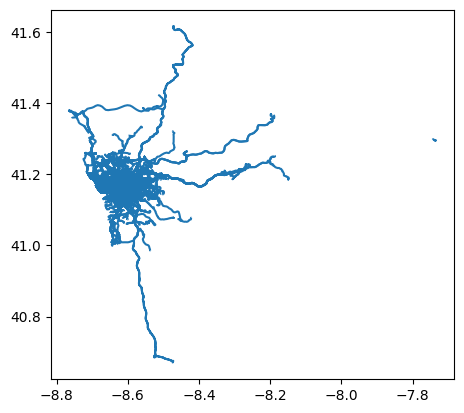

In [6]:
taxi_train_data = df.copy()
taxi_train_data["lines"].plot();

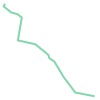

In [7]:
s = taxi_train_data.sample()["lines"].values[0]
s

Here, we grab the last 4 GPS coordinates from the `LineString`. This represents the end of a taxi trip, where a taxi is presumably parking to let a passenger out of their car. We recognize that this is not a perfect solution, as a taxi could be parking for other reasons, but we believe this is a good enough approximation for our purposes.

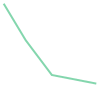

In [8]:
lat, lon = s.coords.xy
list(zip(lat, lon))[-4:]
vis = LineString(list(zip(lat, lon))[-4:])
vis

We calculate the distance by using the `LineString` object

In [9]:
s.distance(s.interpolate(0.5, normalized=True))

1.9106943508410085e-15

In [10]:
taxi_train_data["distances"] = taxi_train_data["lines"].apply(lambda x: LineString(x).length) # x.distance(x.interpolate(0.5, normalized=True)))
taxi_train_data = taxi_train_data[taxi_train_data["distances"].notnull()]
taxi_train_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines,distances
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141...",0.028718
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159...",0.039557
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151...",0.091168
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180...",0.053230
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...","[[-8.615502, 41.140674], [-8.614854, 41.140926...","LINESTRING (-8.61550 41.14067, -8.61485 41.140...",0.060772


We'll define the dataset by taking the last 4 timesteps of the data as an indication of "looking for parking," and then another non-overlapping sample from the same timeseries of 4 timesteps is used for an indication of "not looking for parking."

In [11]:
train_index = taxi_train_data.index
taxi_train_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines,distances
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141...",0.028718
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159...",0.039557
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151...",0.091168
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180...",0.053230
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...","[[-8.615502, 41.140674], [-8.614854, 41.140926...","LINESTRING (-8.61550 41.14067, -8.61485 41.140...",0.060772


In [12]:
s = taxi_train_data.sample()["traj"][-interval:].values[0]
parking_coords = s[-interval:]
parking_coords

[[-8.667846, 41.236614],
 [-8.668737, 41.238648],
 [-8.669979, 41.239071],
 [-8.670357, 41.237928]]

In [13]:
pls = LineString(parking_coords)
pls.distance(pls.interpolate(0.5, normalized=True))

2.989155095786191e-15

In [14]:
def get_random_sample(x, interval=4):
    start_idx = np.random.randint(0, len(x) - 2 * interval)
    return x[start_idx : start_idx + interval]


normal_coords = get_random_sample(s)
normal_coords

[[-8.607636, 41.184756],
 [-8.610381, 41.184351],
 [-8.612154, 41.183631],
 [-8.612856, 41.183406]]

In [15]:
nls = LineString(normal_coords)
nls.distance(nls.interpolate(0.5, normalized=True))

8.8153858471377965e-16

In [16]:
labels = ["normal", "parking"]

parking_coords = taxi_train_data["traj"].apply(lambda x: x[-interval:])
parking_coords.name = "parking_coords"
parking_coords

0       [[-8.630829, 41.154507], [-8.630829, 41.154516...
1       [[-8.668098, 41.168988], [-8.66664, 41.170005]...
3       [[-8.607996, 41.142879], [-8.607987, 41.142888...
4       [[-8.687502, 41.176755], [-8.687259, 41.177781...
5       [[-8.578719, 41.156271], [-8.578629, 41.157693...
                              ...                        
9995    [[-8.620623, 41.146074], [-8.620128, 41.145966...
9996    [[-8.638776, 41.164353], [-8.638776, 41.164344...
9997    [[-8.596863, 41.204925], [-8.596656, 41.204403...
9998    [[-8.670402, 41.238135], [-8.670033, 41.236884...
9999    [[-8.631909, 41.185728], [-8.63208, 41.186484]...
Name: parking_coords, Length: 9399, dtype: object

In [17]:
normal_coords = taxi_train_data["traj"].apply(get_random_sample)
normal_coords.name = "normal_coords"
normal_coords

0       [[-8.627373, 41.144697], [-8.630226, 41.14521]...
1       [[-8.663112, 41.163687], [-8.666235, 41.1642],...
3       [[-8.60328, 41.145597], [-8.604045, 41.145417]...
4       [[-8.667432, 41.178537], [-8.668944, 41.176674...
5       [[-8.613351, 41.14152], [-8.609976, 41.140854]...
                              ...                        
9995    [[-8.667792, 41.154579], [-8.666739, 41.154219...
9996    [[-8.638776, 41.164533], [-8.638767, 41.164488...
9997    [[-8.596485, 41.203845], [-8.596485, 41.203854...
9998    [[-8.622855, 41.204943], [-8.626275, 41.206428...
9999    [[-8.622999, 41.170608], [-8.622234, 41.172381...
Name: normal_coords, Length: 9399, dtype: object

Below are the functions used to create feature data. This allows us to create a dataset of features that we can use to train our model.

In [61]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
features = {}

In [62]:
def calculate_distance1(x):
    ls = LineString(x)
    return ls.length

features["distance1"] = calculate_distance1


In [63]:
def calculate_distance2(x):
    ls = LineString(x)
    return ls.distance(ls.interpolate(0.5, normalized=True))

features["distance2"] = calculate_distance2

In [64]:
def calculate_area(x):
    ls = LineString(x)
    raw_area = ls.convex_hull.area
    return abs(0 if raw_area == 0 else np.log(raw_area))


features["area"] = calculate_area
features

{'distance1': <function __main__.calculate_distance1(x)>,
 'distance2': <function __main__.calculate_distance2(x)>,
 'area': <function __main__.calculate_area(x)>}

Here, we apply each feature function to the dataset and create a new column for each feature.

In [65]:
def generate_features(coords: pd.DataFrame, features: dict, encoding: int):
    concat_features = []
    for name, func in features.items():
        func_output: pd.Series = coords.apply(func)
        func_output.name = name
        func_output = func_output.replace(0, np.nan)
        concat_features.append(func_output)

    concat_features = pd.concat(concat_features, axis=1).dropna().reset_index(drop=True)
    concat_features = scaler.fit_transform(concat_features)
    labels = pd.Series([encoding] * len(concat_features), name="label", dtype=int)
    concat_features = pd.DataFrame(concat_features, columns=features.keys())
    concat_features = pd.concat([concat_features, labels], axis=1)

    return concat_features


normal_data = generate_features(normal_coords, features, encoding=0)
normal_data.describe()

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning:

invalid value encountered in distance



,distance1,distance2,area,label
count,9.152000e+03,9.152000e+03,9.152000e+03,9152.0
mean,-9.006005e-17,-2.554289e-16,-5.978124e-16,0.0
std,1.000055e+00,1.000055e+00,1.000055e+00,0.0
min,-1.149481e+00,-1.394224e+00,-2.242342e+00,0.0
25%,-6.480423e-01,-8.505394e-01,-6.906916e-01,0.0
50%,-2.266966e-01,-2.058007e-01,-1.459067e-01,0.0
75%,3.291472e-01,7.438612e-01,5.268372e-01,0.0
max,1.106249e+01,2.441665e+00,1.234216e+01,0.0


In [66]:
parking_data = generate_features(parking_coords, features, encoding=1)
parking_data

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning:

invalid value encountered in distance



,distance1,distance2,area,label
0,0.410234,1.177156,-0.068434,1
1,-0.748763,-0.925047,1.419900,1
2,-0.215133,-0.748553,-0.134153,1
3,1.056735,-0.976730,-0.793784,1
4,-0.443663,-0.009870,0.386274,1
...,...,...,...,...
8557,-0.552576,1.246805,0.979448,1
8558,-0.748599,1.337053,1.640125,1
8559,0.580206,-0.971886,-0.912805,1
8560,-0.088647,-0.417888,-0.041655,1


In [67]:
def build_data(normal_data, parking_data):
    data = pd.merge(normal_data, parking_data, how="outer")
    return data

train_data = build_data(normal_data, parking_data)
train_data

,distance1,distance2,area,label
0,0.985016,0.753248,-1.359513,0
1,1.065718,2.382806,-0.308680,0
2,0.022315,-0.954803,-0.573171,0
3,1.209984,-1.365140,-0.897618,0
4,1.610993,0.778477,-1.135868,0
...,...,...,...,...
17709,-0.552576,1.246805,0.979448,1
17710,-0.748599,1.337053,1.640125,1
17711,0.580206,-0.971886,-0.912805,1
17712,-0.088647,-0.417888,-0.041655,1


In [68]:
from collections import Counter

console.print(Counter(train_data["label"]))

Counter({0: 9152, 1: 8562})

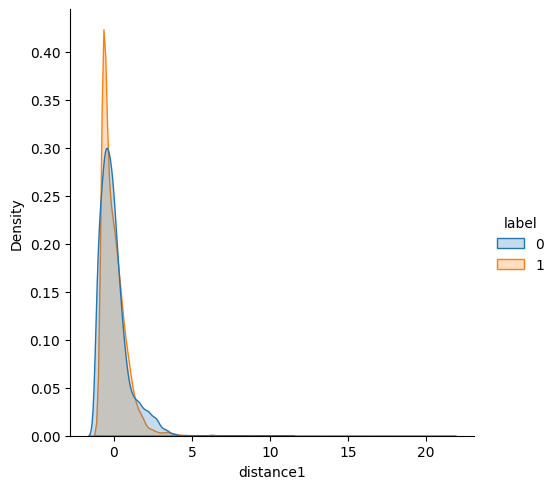

In [69]:
import seaborn as sns

sns.displot(train_data, x="distance1", hue="label", kind="kde", fill=True);


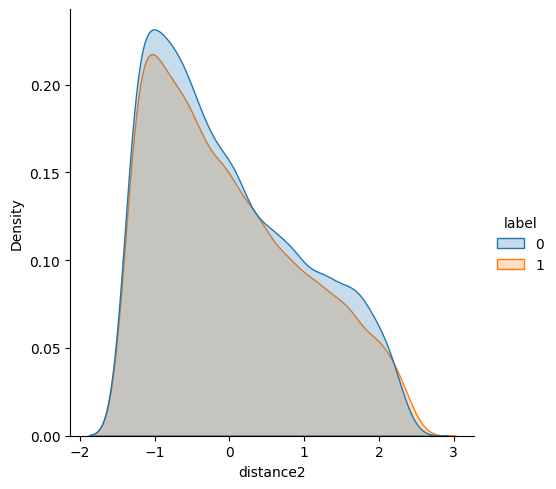

In [70]:
sns.displot(train_data, x="distance2", hue="label", kind="kde", fill=True);

We see here this distance type has a lot of overlap between the two classes, so we ultimately drop this feature.

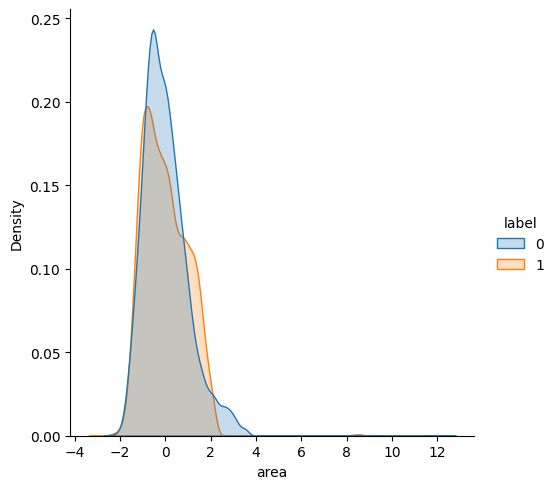

In [71]:
sns.displot(train_data, x="area", hue="label", kind="kde", fill=True);

We will now create our training and test splits.

In [72]:
train_data

,distance1,distance2,area,label
0,0.985016,0.753248,-1.359513,0
1,1.065718,2.382806,-0.308680,0
2,0.022315,-0.954803,-0.573171,0
3,1.209984,-1.365140,-0.897618,0
4,1.610993,0.778477,-1.135868,0
...,...,...,...,...
17709,-0.552576,1.246805,0.979448,1
17710,-0.748599,1.337053,1.640125,1
17711,0.580206,-0.971886,-0.912805,1
17712,-0.088647,-0.417888,-0.041655,1


In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop("label", axis=1).values,
    train_data["label"].values,
    test_size=0.2,
    random_state=random_state,
    stratify=train_data["label"].values,
)
y_train.shape, y_test.shape

((14171,), (3543,))

Lets look at the distribution of the training data:

We can see from this density plot that the data is skewed towards the "not looking for parking" class. This is expected, as most of the time, people are not looking for parking. However, this is a problem for us, as we want to train a model that can accurately predict both classes.

# Experiments

Here we have two main experiments: experiment 1 investigates different machine learning models for the parking driver profile, while experiment 2 demonstrates the model's ability to predict parking behavior in a real-time setting using user collected data.

## Experiment 1: Model training and evaluation
Here we train 3 machine learning models and measure the performance of each model. We use the following models:
- Logistic Regression
- Support Vector Machine
- Random Forest
- XGBoost

For metrics, we use the following:

- Accuracy
- Precision
- Recall
- F1 Score
- ROC AUC

These metrics are commonly used in classification problems, and thus we will use them to evaluate our models. Each metric is presented for every split. Cross validation is performed on the training data, and the best model is selected based on the ROC_AUC of the model.


In [74]:
from sklearn.model_selection import GridSearchCV

refit = "roc_auc"
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
split_names = ["train", "test"]


### `Logistic Regression`

In [75]:
from sklearn.linear_model import LogisticRegression

params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "max_iter": [1000, 2500, 5000],
}
logr = GridSearchCV(
    LogisticRegression(),
    params,
    cv=5,
    verbose=2,
    n_jobs=-1,
    refit=refit,
    scoring=scoring,
    return_train_score=True,
)
logr.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [1000, 2500, 5000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

We'll start keeping track of all of the results for easy documentation later:

In [76]:
def collect_metrics(model_name: str, results: dict):
    result = [model_name]
    split_metric_names = ["model_name"]
    for split in split_names:
        for metric in scoring:
            split_metric_name = "_".join(["mean", split, metric])
            split_metric_names.append(split_metric_name)

    for split_metric_name in split_metric_names[1:]:
        # print(split_metric_name, logr_results[split_metric_name].mean())
        result.append(results[split_metric_name].mean())

    return pd.DataFrame([result], columns=split_metric_names).set_index("model_name")

logr_results = collect_metrics("LogisticRegression", logr.cv_results_)
logr_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
LogisticRegression,0.513566,0.250261,0.00121,0.00238,0.506699,0.51394,0.252288,0.0011,0.002175,0.496346


### `RandomForestClassifier`

In [77]:
from sklearn.ensemble import RandomForestClassifier

params = {
    "n_estimators": [10, 100, 1000],
    # "max_depth": [None, 5, 10, 20],
    # "max_features": ["auto", "sqrt", "log2"],
    # "criterion": ["gini", "entropy"],
}
rf = GridSearchCV(
    RandomForestClassifier(),
    params,
    cv=5,
    verbose=3,
    n_jobs=-1,
    refit=refit,
    scoring=scoring,
    return_train_score=True,
)
rf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 100, 1000]}, refit='roc_auc',
             return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=3)

In [78]:
rf_results = collect_metrics("RandomForestClassifier", rf.cv_results_)
rf_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
RandomForestClassifier,0.994749,0.997291,0.9918,0.994522,0.999632,0.684331,0.675604,0.668175,0.671231,0.778656


### `SVC`

In [79]:
from sklearn.svm import SVC

params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
}
svc = GridSearchCV(
    SVC(), params, cv=5, verbose=2, n_jobs=-1, refit=refit, scoring=scoring, return_train_score=True
)
svc.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [80]:
svc_results = collect_metrics("SVC", svc.cv_results_)
svc_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
SVC,0.544964,0.481205,0.291837,0.283186,0.558162,0.545187,0.476661,0.292044,0.283527,0.55905


### `XGBoost`

In [81]:
import xgboost as xgb

params = {
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
    "objective": ["binary:logistic"],
}

xg = GridSearchCV(
    xgb.XGBClassifier(),
    params,
    cv=5,
    verbose=2,
    n_jobs=-1,
    refit=refit,
    scoring=scoring,
    return_train_score=True,
)
xg.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'objective': ['binary:logistic']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [82]:
xg_results = collect_metrics("XGBClassifier", xg.cv_results_)
xg_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
XGBClassifier,0.808443,0.812066,0.78558,0.79003,0.887706,0.684052,0.686577,0.65801,0.663469,0.781854


### Training results

In [83]:
results = pd.concat([logr_results, rf_results, svc_results, xg_results])
results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
LogisticRegression,0.513566,0.250261,0.001210,0.002380,0.506699,0.513940,0.252288,0.001100,0.002175,0.496346
RandomForestClassifier,0.994749,0.997291,0.991800,0.994522,0.999632,0.684331,0.675604,0.668175,0.671231,0.778656
SVC,0.544964,0.481205,0.291837,0.283186,0.558162,0.545187,0.476661,0.292044,0.283527,0.559050
XGBClassifier,0.808443,0.812066,0.785580,0.790030,0.887706,0.684052,0.686577,0.658010,0.663469,0.781854


In [84]:
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_filename = f"results/{now}_experiment1_train_results.csv"
print(f"Saving results to '{save_filename}'")
results.to_csv(save_filename)

Saving results to 'results/2023-12-01_02-21-23_experiment1_train_results.csv'


Now we get the same information for the test split using each fitted model:

Results for:	LogisticRegression

ROC AUC:	0.5

              precision    recall  f1-score   support

      normal     0.5168    1.0000    0.6814      1831
     parking     0.0000    0.0000    0.0000      1712

    accuracy                         0.5168      3543
   macro avg     0.2584    0.5000    0.3407      3543
weighted avg     0.2671    0.5168    0.3522      3543



c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set t

,acc,precision,recall,f1,roc_auc
model_name,,,,,
LogisticRegression,0.516794,0.258397,0.5,0.340715,0.5


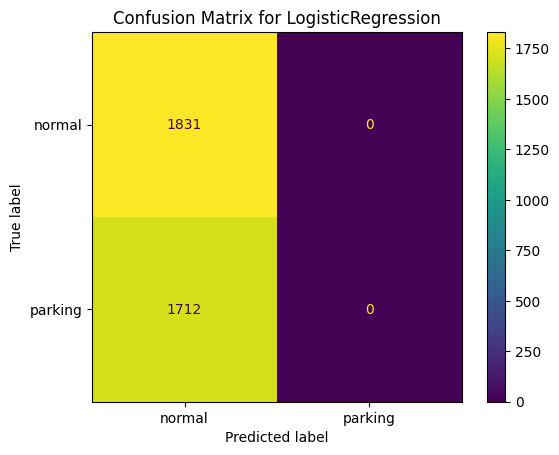

In [85]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)


def get_evaluation_results(model, X_test, y_test):
    macro_avg = "macro avg"
    y_pred = model.predict(X_test)
    cfm = confusion_matrix(y_test, y_pred)
    model_name = model.best_estimator_.__class__.__name__
    print(f"Results for:\t{model_name}\n")
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC:\t{roc_auc}\n")
    cr = classification_report(y_test, y_pred, digits=4, target_names=labels)
    cr_dict = classification_report(
        y_test, y_pred, digits=4, target_names=labels, output_dict=True
    )
    print(cr)
    cfm_display = ConfusionMatrixDisplay(cfm, display_labels=labels)
    cfm_display.plot()
    cfm_display.ax_.set_title(f"Confusion Matrix for {model_name}")

    cfm = pd.DataFrame(cfm, columns=labels, index=labels)
    cr = pd.DataFrame.from_dict(cr_dict).T

    precision = cr.loc[macro_avg]["precision"]
    recall = cr.loc[macro_avg]["recall"]
    f1 = cr.loc[macro_avg]["f1-score"]

    results = pd.DataFrame(
        {
            "model_name": model_name,
            "acc": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
        },
        index=[0],
    ).set_index("model_name")

    return results


logr_results = get_evaluation_results(logr, X_test, y_test)
logr_results

Results for:	RandomForestClassifier

ROC AUC:	0.7005492121663766

              precision    recall  f1-score   support

      normal     0.7146    0.7002    0.7073      1831
     parking     0.6861    0.7009    0.6934      1712

    accuracy                         0.7005      3543
   macro avg     0.7004    0.7005    0.7004      3543
weighted avg     0.7008    0.7005    0.7006      3543



,acc,precision,recall,f1,roc_auc
model_name,,,,,
RandomForestClassifier,0.700536,0.700355,0.700549,0.700376,0.700549


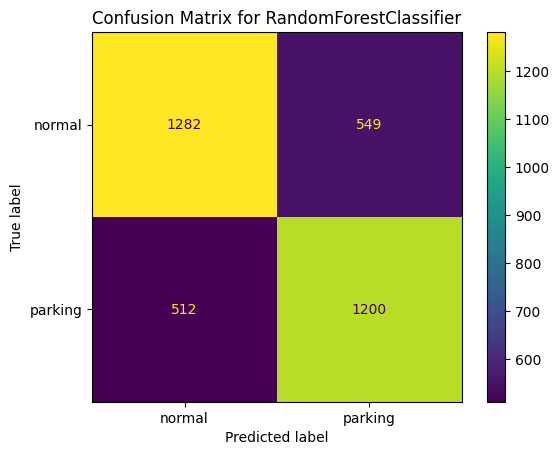

In [86]:
rf_results = get_evaluation_results(rf, X_test, y_test)
rf_results

Results for:	SVC

ROC AUC:	0.6793058412491004

              precision    recall  f1-score   support

      normal     0.7566    0.5467    0.6347      1831
     parking     0.6261    0.8119    0.7070      1712

    accuracy                         0.6749      3543
   macro avg     0.6914    0.6793    0.6709      3543
weighted avg     0.6936    0.6749    0.6697      3543



,acc,precision,recall,f1,roc_auc
model_name,,,,,
SVC,0.674852,0.69137,0.679306,0.670884,0.679306


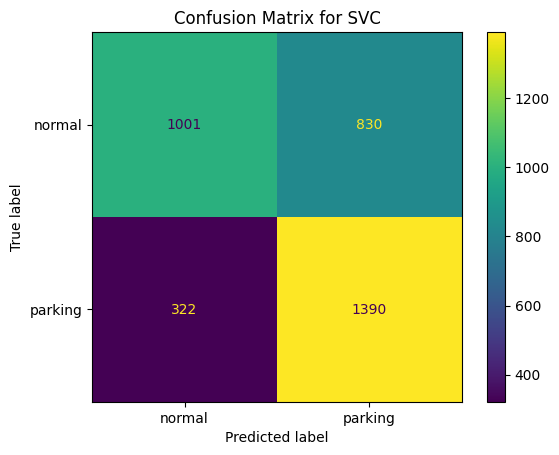

In [87]:
svc_results = get_evaluation_results(svc, X_test, y_test)
svc_results

Results for:	XGBClassifier



ROC AUC:	0.7117918557348265

              precision    recall  f1-score   support

      normal     0.7358    0.6876    0.7109      1831
     parking     0.6878    0.7360    0.7111      1712

    accuracy                         0.7110      3543
   macro avg     0.7118    0.7118    0.7110      3543
weighted avg     0.7126    0.7110    0.7110      3543



,acc,precision,recall,f1,roc_auc
model_name,,,,,
XGBClassifier,0.710979,0.7118,0.711792,0.710979,0.711792


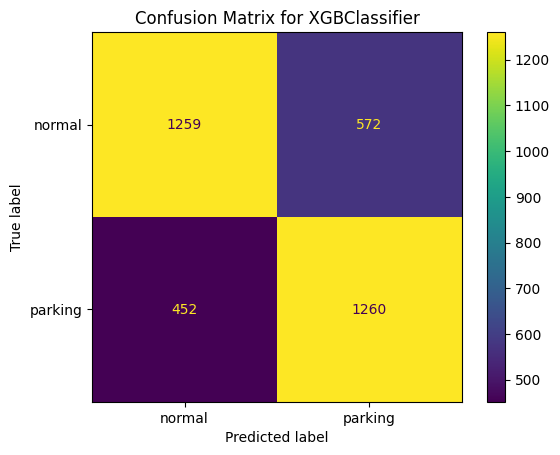

In [88]:
xg_results = get_evaluation_results(xg, X_test, y_test)
xg_results

In [89]:
experiment1_results = pd.concat([logr_results, rf_results, svc_results, xg_results])
experiment1_results.to_csv(f"results/{now}_experiment1_test_results.csv")
experiment1_results

,acc,precision,recall,f1,roc_auc
model_name,,,,,
LogisticRegression,0.516794,0.258397,0.500000,0.340715,0.500000
RandomForestClassifier,0.700536,0.700355,0.700549,0.700376,0.700549
SVC,0.674852,0.691370,0.679306,0.670884,0.679306
XGBClassifier,0.710979,0.711800,0.711792,0.710979,0.711792


Based on the results above, we see that `XGBoost` performs the best on the test split. We will use this model for our real-time prediction experiment.

## Experiment 2: Prediction on user collected data

Additional real worl data was collected via a GPS logging mobile application. The data is sampled at 1 second intervals, so we must resample the data to align with the sampling interval of the taxi dataset.

In [90]:
current_interval = 60
test_data_files = [
    "data/test/trip1.csv",
    "data/test/trip2.csv",
    "data/test/trip3.csv",
    "data/test/track_points.csv",
]
resample_num = current_interval // interval
models = [logr, rf, svc, xg]

model_results = {}
for model in models:
    model_name = model.best_estimator_.__class__.__name__
    model_results[model_name] = []

for test_file in test_data_files:
    console.print(f"Results for file: '{test_file}'")
    data = pd.read_csv(test_file)
    if test_file == "data/test/track_points.csv":
        lats, lons = data["X"].values, data["Y"].values
    else:
        lats, longs = data["latitude"].values, data["longitude"].values
    data = list(zip(lats, longs))[-current_interval:]
    d1 = calculate_distance1(data)
    d2 = calculate_distance2(data)
    area = calculate_area(data)

    features = scaler.transform(np.array([d1, d2, area]).reshape(1, -1))
    console.print(f"Features: {features}")


    for model in models:
        model_name = model.best_estimator_.__class__.__name__
        pred = model.best_estimator_.predict(features)[0]
        model_results[model_name].append(pred)
        label = labels[pred]
        l = f"{model_name}: '{label}' ({pred})"
        console.print(l)

    console.print("")

Results for file: 'data/test/trip1.csv'

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Features: [[ 1.4803019   2.39723971 -1.48498684]]

LogisticRegression: 'normal' (0)

RandomForestClassifier: 'parking' (1)

SVC: 'parking' (1)

XGBClassifier: 'parking' (1)

Results for file: 'data/test/trip2.csv'

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Features: [[ 0.51273504  0.29004556 -1.18488577]]

LogisticRegression: 'normal' (0)

RandomForestClassifier: 'parking' (1)

SVC: 'parking' (1)

XGBClassifier: 'parking' (1)

Results for file: 'data/test/trip3.csv'

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Features: [[ 0.55808585  1.99924347 -1.2323439 ]]

LogisticRegression: 'normal' (0)

RandomForestClassifier: 'parking' (1)

SVC: 'parking' (1)

XGBClassifier: 'parking' (1)

Results for file: 'data/test/track_points.csv'

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Features: [[22.07740547 -0.08212875 -2.35031293]]

LogisticRegression: 'normal' (0)

RandomForestClassifier: 'parking' (1)

SVC: 'normal' (0)

XGBClassifier: 'normal' (0)

In [91]:
model_results

{'LogisticRegression': [0, 0, 0, 0],
 'RandomForestClassifier': [1, 1, 1, 1],
 'SVC': [1, 1, 1, 0],
 'XGBClassifier': [1, 1, 1, 0]}

In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score


ground_truth = [1, 1, 1, 1]
records = []

for model_name, results in model_results.items():
    # console.print(f"Results for model: '{model_name}'")
    acc = accuracy_score(ground_truth, results)
    precision = precision_score(ground_truth, results)
    recall = recall_score(ground_truth, results)
    f1 = f1_score(ground_truth, results)

    records.append(
        {
            "model_name": model_name,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            # "roc_auc": roc_auc,
        }
    )

test_results = pd.DataFrame(records).set_index("model_name")
test_results

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



,accuracy,precision,recall,f1
model_name,,,,
LogisticRegression,0.00,0.0,0.00,0.000000
RandomForestClassifier,1.00,1.0,1.00,1.000000
SVC,0.75,1.0,0.75,0.857143
XGBClassifier,0.75,1.0,0.75,0.857143


In [107]:
test_results.to_csv(f"results/{now}_experiment2_test_results.csv")

We see here that the `RandomForestClassifier` performs the best on the test split, getting an accuracy of 1.0. The worst performing was `LogisticRegression`, getting all classifications incorrect. Keep in mind this hold out test set is very small, so there is high variance in the results.

# Demo

Lastly, we present an example of the use case for our model using the Google Maps API.

In [100]:
from geopy.geocoders import GoogleV3
api_key_file = "GOOGLE_MAPS_API_KEY.txt"


In [101]:
with open(api_key_file, "r") as f:
    api_key = f.read()
adapter = GoogleV3(api_key=api_key)


In [102]:
test_file = "data/test/track_points.csv"
data = pd.read_csv(test_file)
lon, lat = data["X"].values, data["Y"].values
data = list(zip(lat, lon))[-current_interval:]
d1 = calculate_distance1(data)
d2 = calculate_distance2(data)
area = calculate_area(data)

features = scaler.transform(np.array([d1, d2, area]).reshape(1, -1))
console.print(f"Features: {features}")


for model in [rf]:
    model_name = model.best_estimator_.__class__.__name__
    pred = model.best_estimator_.predict(features)[0]
    model_results[model_name].append(pred)
    label = labels[pred]
    l = f"{model_name}: '{label}' ({pred})"
    console.print(l)

    if pred == 1:
        console.print("Predicted parking, getting address...")
        lat, lon = data[-1]
        location = adapter.reverse((lat, lon))
        console.print(f"Address: {location.address}")
        console.print(f"Latitude: {lat}")
        console.print(f"Longitude: {lon}")

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



Features: [[-0.66560037  2.34822294  0.96610293]]

RandomForestClassifier: 'parking' (1)

Predicted parking, getting address...

Address: Helipad, 844 Swift Blvd, Richland, WA 99352, USA

Latitude: 46.28175905

Longitude: -119.2815295

In [103]:
import requests

request_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?"
radius = 1000 # meters
type_ = "parking"
location = f"{lat},{lon}"
request_url = f"{request_url}location={location}&radius={radius}&type={type_}&key={api_key}"
# request_url

In [104]:
res = requests.get(request_url).json()
res["results"][0]

{'business_status': 'OPERATIONAL',
 'geometry': {'location': {'lat': 46.2807432, 'lng': -119.2801804},
  'viewport': {'northeast': {'lat': 46.2820928302915,
    'lng': -119.2788648697085},
   'southwest': {'lat': 46.2793948697085, 'lng': -119.2815628302915}}},
 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/parking-71.png',
 'icon_background_color': '#7B9EB0',
 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/parking_pinlet',
 'name': 'Kadlec Regional Medical Center Parking Structure',
 'photos': [{'height': 4032,
   'html_attributions': ['<a href="https://maps.google.com/maps/contrib/103726264075044178111">Aric Clark</a>'],
   'photo_reference': 'AWU5eFi02RCk-_Ct_zglmbwMNNMA_ssSMihzyBXz9fW1J37vp2ULX_CYnJAvsdMfYD3p_VvZz_JMTBrAjqpmqDeezesdGsza_3qfBfotROOc3hWBdY71NfouYiDZORBwqRI2WcKAX05t3GtS-bOazT52Jvn89gRf9i-ALSHbyu1nhIJya_IR',
   'width': 3024}],
 'place_id': 'ChIJA_XPYe17mFQRIaCp4allZAs',
 'plus_code': {'compound_code': '7PJ9+7W Richlan

In [105]:
def get_nearest_parking(lat: int = 0.0, lon: int = 0.0, query: str = None, radius=1000):
    if query is not None:
        loc = adapter.geocode(query)
        lat, lon = loc.latitude, loc.longitude
    request_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?"
    location = f"{lat},{lon}"
    request_url = (
        f"{request_url}location={location}&radius={radius}&type=parking&key={api_key}"
    )
    res = requests.get(request_url).json()

    return res["results"]


nearby_parking = get_nearest_parking(lat, lon)
nearby_parking[0]["geometry"]["location"]

{'lat': 46.2807432, 'lng': -119.2801804}

In [106]:
cases = []

for parking in nearby_parking:
    lat = parking["geometry"]["location"]["lat"]
    lng = parking["geometry"]["location"]["lng"]
    cases.append((lat, lng))
    print(parking["vicinity"], (lat, lng))


Richland (46.2807432, -119.2801804)
951-999 Jadwin Avenue, Richland (46.2793161, -119.2760496)
651 Mansfield Street, Richland (46.27912449999999, -119.2762091)
1132 Knight Street, Richland (46.2768508, -119.2792545)
829 Northgate Drive, Richland (46.2770207, -119.2782732)
Knight Street, Richland (46.2770153, -119.2782359)
Richland (46.2768178, -119.2792327)
